In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import pickle
import numpy as np
import flowpm
from flowpm.tfpower import linear_matter_power
from itertools import cycle
from astropy.cosmology import Planck15
import astropy.units as u
from flowpm.NLA_IA import k_IA
from flowpm.fourier_smoothing import fourier_smoothing
from flowpm.redshift import LSST_Y1_tomog
from flowpm.tfbackground import rad_comoving_distance
from astropy.io import fits
import flowpm.scipy.interpolate as interpolate
import flowpm.scipy.integrate as integrate

Populating the interactive namespace from numpy and matplotlib


## Let's Start the simulation

In [2]:
# Loads PGD parameters
with open('/global/u1/d/dlan/DifferentiableHOS/notebooks/results_fit_PGD_205_128.pkl', "rb") as f:
    pgd_data = pickle.load(f)
    pgdparams = pgd_data['params']

In [3]:
# Below are a few parameters
n_lens = 11       # Number of lensplanes in the lightcone
box_size = 205.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field 
batch_size = 1    # Number of simulations to run in parallel

In [4]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [5]:

#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [6]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True,
                      pgdparams=pgdparams) 

In [7]:
%%time
# Extract the lensplanes
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    plane = fourier_smoothing(plane,sigma=1.024,resolution=2048)
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

CPU times: user 54.3 s, sys: 21 s, total: 1min 15s
Wall time: 40.4 s


In [8]:
z_center=1/a_center-1


In [9]:
k=LSST_Y1_tomog(cosmology, 
                lensplanes, 
                box_size, 
                z_center,
                field_npix,
                5,
                3,
                1,
                use_A_ia=False,
                Aia=None)
kia=LSST_Y1_tomog(cosmology, 
                lensplanes, 
                box_size, 
                z_center,
                field_npix,
                5,
                3,
                1,
                use_A_ia=True,
                Aia=1.)

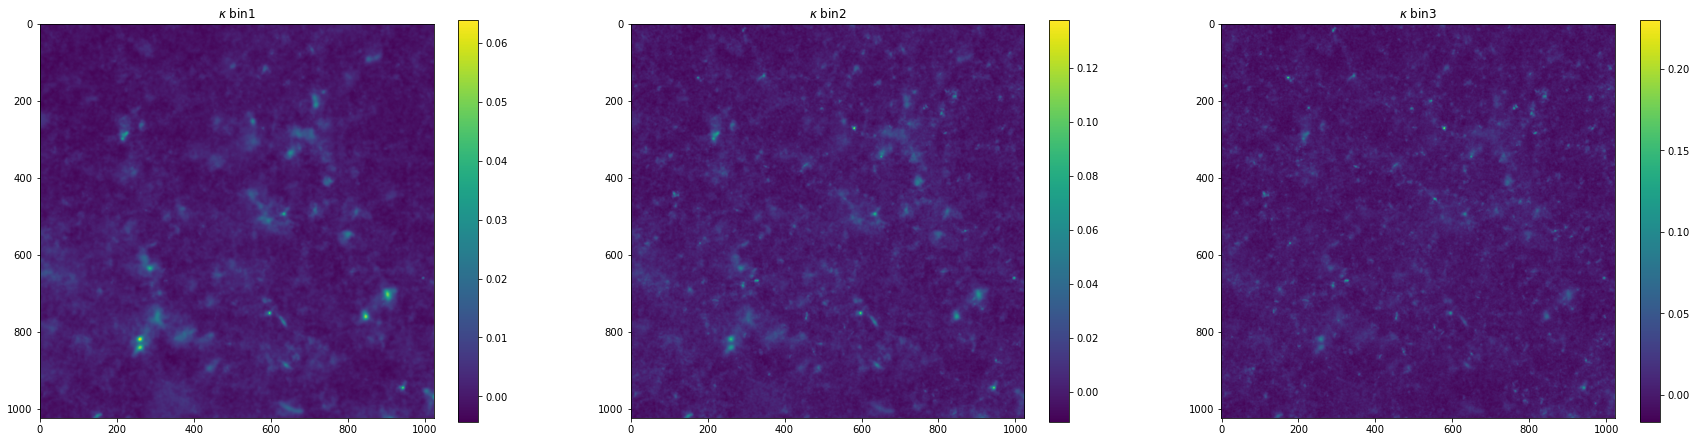

In [10]:
figure(figsize=[30,10])
subplot(131)
imshow(k[0])
title('$\kappa$ bin1')
colorbar(shrink=0.74)
subplot(132)
imshow(k[1])
title('$\kappa$ bin2')
colorbar(shrink=0.74)
subplot(133)
imshow(k[2])
title('$\kappa$ bin3')
colorbar(shrink=0.74)

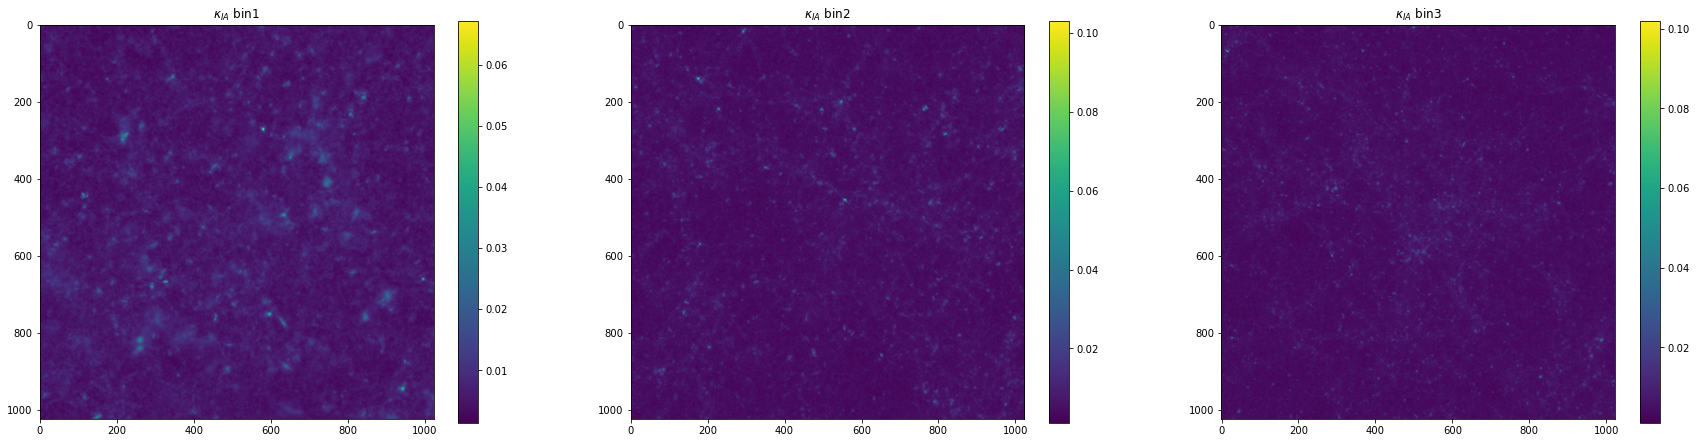

In [11]:
figure(figsize=[30,10])
subplot(131)
imshow(-kia[0])
title('$\kappa_{IA}$ bin1')
colorbar(shrink=0.74)
subplot(132)
imshow(-kia[1])
title('$\kappa_{IA}$ bin2')
colorbar(shrink=0.74)
subplot(133)
imshow(-kia[2])
title('$\kappa_{IA}$ bin3')
colorbar(shrink=0.74)

In [12]:
np.save("m_array.npy",k)
np.save("k_ia_array.npy",kia)

# Let's see how the redshift distribution looks like

In [13]:
# Load the redshift distribution:
hdul = fits.open('lsst_y1.fits')
data=hdul[1].data
hdr=hdul[1].header

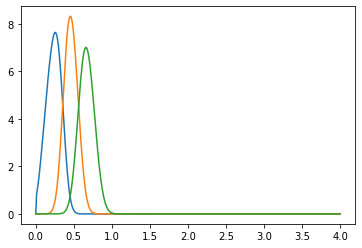

In [14]:
for i in range(3):
    plot(data['Z'],data["BIN_%s " % (i)])


In [15]:
norm = integrate.simps(lambda t: (t**2)*np.exp(-((t/0.26)**0.94)), min(data['Z']), max(data['Z']))

In [16]:
nz=[]
for i in range(3):
    nz.append(interpolate.interp_tf(z_center,data['Z'],tf.cast(data["BIN_%s " % (i)]*norm,dtype=tf.float32)))

(0.0, 1.5)

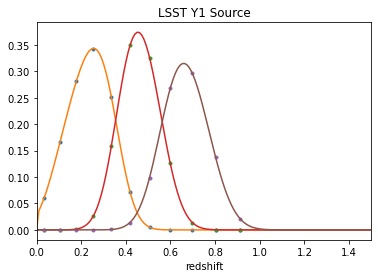

In [17]:
for i in range(3):
    plot(z_center,nz[i],'.')
    plot(data['Z'],data["BIN_%s " % (i)]*norm)
title('LSST Y1 Source')
xlabel('redshift')
xlim(0,1.5)

In [18]:
np.save("nz.npy",np.stack(nz))